In [297]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import json
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
import random

## 2 Localisation
### 2.1 Dataset & dataloader


В задаче детекции участвовали фотографии 20 классов:
- black_kite
- chaffinch
- common_magpie
- common_raven
- crested_tit
- eurasian_jay
- eurasian_pygmy-owl
- eurasian_tree_sparrow
- european_turtle-dove
- great_spotted_woodpecker
- hazel_grouse
- northern_harrier
- rock_pigeon
- ruddy_shelduck
- snow_goose
- snowy_owl
- waxwing
- white_stork
- white_wagtail
- willow_grouse

Изображения распологаются в соответствующих папках в `bird_imgs`.
С помощью Label Studio для каждого изображения были найдены bounding boxы. json-файл с координатами и лэйблами располагается в папке `bird_bbox`

In [298]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [299]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


In [300]:
data_path = './bird_dataset/' #путь до папки с датасетом
img_path = './bird_dataset/bird_imgs'
json_path = './bird_dataset/bird_bbox/'

## test

In [301]:
with open(os.path.join(json_path , 'bird_bboxes.json'), 'r') as j:
          objects = json.load(j)

In [302]:
detections = objects[658]['annotations'][0]['result']

In [303]:
for obj in detections:
    print(obj['value'])

{'x': 12.266666666666667, 'y': 34.50413223140496, 'width': 24.266666666666662, 'height': 53.30578512396694, 'rotation': 0, 'rectanglelabels': ['white_stork']}
{'x': 53.2, 'y': 28.09917355371901, 'width': 36, 'height': 50.6198347107438, 'rotation': 0, 'rectanglelabels': ['white_stork']}
{'x': 34, 'y': 44.21487603305785, 'width': 30.00000000000001, 'height': 32.64462809917355, 'rotation': 0, 'rectanglelabels': ['white_stork']}
{'x': 44.53333333333333, 'y': 25.826446280991735, 'width': 45.333333333333336, 'height': 48.14049586776859, 'rotation': 0, 'rectanglelabels': ['white_stork']}


In [304]:
values = [det['value'] for det in detections]

In [305]:
img_name = objects[658]['file_upload']
labels = [value['rectanglelabels'][0] for value in values]
labels

['white_stork', 'white_stork', 'white_stork', 'white_stork']

In [306]:
img_folder = Path(img_path)
image = PIL.Image.open(img_folder / labels[0] / img_name )


In [307]:
values[0]['rectanglelabels'][0]

'white_stork'

In [308]:
[value['rectanglelabels'][0] for value in values]

['white_stork', 'white_stork', 'white_stork', 'white_stork']

In [309]:
def get_bbox(value):
    bbox_x = value['x']
    bbox_y = value['y']
    width = value['width']
    height = value['height']
    return [bbox_x, bbox_y, width, height]

In [310]:
boxes = [get_bbox(value) for value in values]
boxes

[[12.266666666666667,
  34.50413223140496,
  24.266666666666662,
  53.30578512396694],
 [53.2, 28.09917355371901, 36, 50.6198347107438],
 [34, 44.21487603305785, 30.00000000000001, 32.64462809917355],
 [44.53333333333333,
  25.826446280991735,
  45.333333333333336,
  48.14049586776859]]

In [311]:
new_boxes = [[(100 - box[0] - box[2]), box[1], box[2], box[3]] for box in boxes]
new_boxes

[[63.46666666666667, 34.50413223140496, 24.266666666666662, 53.30578512396694],
 [10.799999999999997, 28.09917355371901, 36, 50.6198347107438],
 [35.999999999999986, 44.21487603305785, 30.00000000000001, 32.64462809917355],
 [10.133333333333333,
  25.826446280991735,
  45.333333333333336,
  48.14049586776859]]

## Dataset & Dataloader

In [312]:
IMG_SIZE = [224, 224]
BATCH_SIZE = 40

In [313]:
# get bounding box parameters for each object
def get_bbox(value):
    bbox_x = value['x']
    bbox_y = value['y']
    width = value['width']
    height = value['height']
    return [bbox_x, bbox_y, width, height]

In [314]:
labels = sorted(os.listdir(img_path))
label_dict = {labels[i]:i for i in range(0, len(labels))}
re_label_dict = {i:labels[i] for i in range(0, len(labels))}

In [315]:
def map_label(label):
    return label_dict[label]

In [316]:
def horizontal_flip(image, boxes):
    # Flip image horizontally with bounding boxes
    h_flip = transforms.RandomHorizontalFlip(p=1)
    flip_image = h_flip(image)
    # change only x values
    flip_boxes = [[(100 - box[0] - box[2]), box[1], box[2], box[3]] for box in boxes]
    
    return flip_image, flip_boxes


In [317]:
def transform(image, boxes, labels,  img_size, split):
    # different transformations for 'train' or 'test' splits
    assert split in {'TRAIN', 'TEST'}

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    new_image = image
    new_boxes = boxes
    new_labels = labels

    if split == 'TRAIN':

        img_blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        img_autocontrast = transforms.RandomAutocontrast(p=0.3)

        # 0.5 probability of horizontal flip
        if random.random() < 0.5:
            new_image, new_boxes = horizontal_flip(new_image, new_boxes)
        
        if random.random() < 0.3:
            new_image = img_blurrer(new_image)
            new_image = img_autocontrast(new_image)


    base_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize(img_size),
                                         transforms.Normalize(mean=mean, std=std)]) 
       
    new_image = base_transform(new_image)

    return new_image, new_boxes, new_labels


In [318]:
class BBoxDataset(Dataset):

    def __init__(self, img_folder, json_folder, img_size, split):

        super().__init__()
        self.img_folder = Path(img_folder)
        self.json_folder = Path(json_folder)
        self.img_size = img_size

        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}

        with open(os.path.join(self.json_folder , 'bird_bboxes.json'), 'r') as j:
          objects = json.load(j)
        self.objects = sorted(objects, key=lambda k: k['annotations'][0]['task'])


    def __len__(self):
        return len(self.objects)
    
    def __getitem__(self, idx):
        img_name = self.objects[idx]['file_upload']
        obj = self.objects[idx]
        detections = obj['annotations'][0]['result']
        values = [det['value'] for det in detections]
        boxes = [get_bbox(value) for value in values]
        labels = [map_label(value['rectanglelabels'][0]) for value in values]

        class_label = re_label_dict[labels[0]]
        image = PIL.Image.open(self.img_folder / class_label / img_name )

        # apply transformations
        image, boxes, labels = transform(image, boxes, labels, img_size=self.img_size, split=self.split)

        return {'image': image, 'bboxes': torch.FloatTensor(boxes), 'labels': torch.LongTensor(labels)}

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)
        return images, boxes, labels


In [319]:
bird_set = BBoxDataset(img_path, json_path, img_size=IMG_SIZE, split='train')

In [320]:
train_size = int(0.8 * len(bird_set))
test_size = len(bird_set) - train_size
train_set, test_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, test_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [321]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Dataset visualization 

In [322]:
def draw_a_box(box, label, color):
    class_label = re_label_dict[label.item()]
    # coordinates of the upper left corner and width, height in percent 
    x, y, w, h = box

    # create bounding box
    X = (x/100)*IMG_SIZE[0]
    Y = (y/100)*IMG_SIZE[0]
    W = (w/100)*IMG_SIZE[0]
    H = (h/100)*IMG_SIZE[0]
    
    rect = patches.Rectangle((X, Y), W, H, 
                          linewidth=1, 
                          edgecolor=color,
                          facecolor='none')
    ax.add_patch(rect)
    ax.text(X, (Y), class_label,
              horizontalalignment='left',
              verticalalignment='bottom',
              color=color)
    
    return ax

In [323]:
def show_image(images, bboxes, labels, is_pred=False):
    
    img = np.moveaxis(images.numpy(), 0, 2)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

    # f, ax = plt.subplots()
    
    for box, label in zip(bboxes, labels):
        ax = draw_a_box(box, label, 'green')
  
    if is_pred:
        with torch.no_grad():
            boxes_pred, label_pred = model(torch.unsqueeze(img_tensor, dim=0).to(device)).cpu().numpy()[0].argmax()

            for box_pred, label_pred in zip(boxes_pred, label_pred):
                ax = draw_a_box(box_pred, label_pred, 'red')

    ax.imshow(img.clip(0,1))
    return ax
    # plt.show()

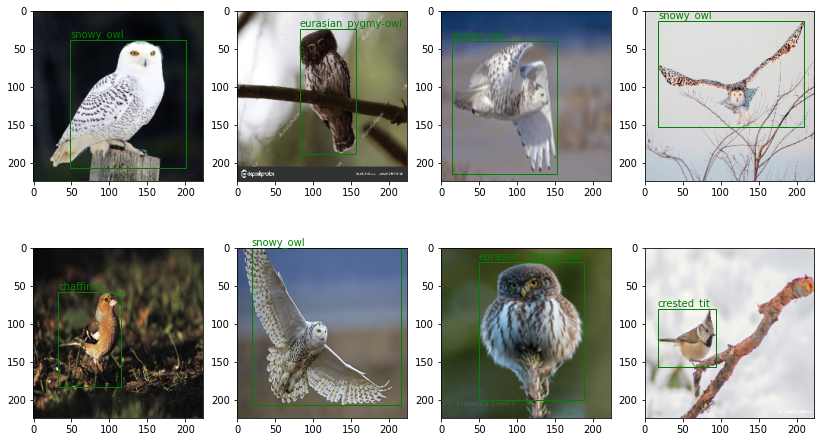

In [326]:
f = plt.figure(figsize=(14, 8))
rows = 2
columns = 4
for i in range(1,columns*rows+1):
    idx = np.random.randint(0, len(train_set))
    img_tensor = train_set[idx]['image']
    boxes = train_set[idx]['bboxes']
    labels = train_set[idx]['labels']

    ax = f.add_subplot(rows, columns, i)
    ax = show_image(img_tensor, boxes, labels, is_pred=False)

# plt.show()

In [ ]:
def samples_set_visualization(data_set, rows, columns, is_pred=False):
    '''
    data_set: train, validation or test dataset
    rows, columns: how many imgs to show 
    is_pred: are any predictions?
    '''
    # rows = image_grid[0]
    # columns = image_grid[1]
    f = plt.figure(figsize=(10, 7))
    for i in range(1, columns*rows+1):
        idx = np.random.randint(0, len(data_set))
        img_tensor = data_set[idx]['image']
        boxes = data_set[idx]['bboxes']
        labels = data_set[idx]['labels']

        ax = f.add_subplot(rows, columns, i)
        ax = show_image(img_tensor, boxes, labels, is_pred=False)
    f.show()       
            

### 2.2  Network architecture

Для начала решила взять Resnet18. В дальнейшем попробую Yolo

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = resnet18(pretrained=True)
# net = resnet50(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
loss_function_xy = torch.nn.L1Loss()
loss_function_bce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(100):

    net.train()
    epoch_loss = 0.

    for batch in train_loader:
        images, xy, labels = batch['image'], batch['xy'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = net(images)

        
        loss = loss_function_xy(predictions, xy)/BATCH_SIZE

        #+ loss_function_bce(predictions[:, :10], labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Train: {epoch_loss / len(train_loader)}')

    net.eval()
    epoch_loss = 0.

    for batch in test_loader:
        images, xy, labels = batch['image'], batch['xy'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        predictions = net(images)

        with torch.no_grad():
            
            loss = loss_function_xy(predictions, xy)/BATCH_SIZE

        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(test_loader)}')

Train: 2.7337795893351235
Test: 2.5402424335479736
Train: 2.709577480951945
Test: 1.9317924976348877
Train: 2.6621810595194497
Test: 2.1194911003112793
Train: 2.6143321990966797
Test: 2.157566785812378
Train: 2.567158063252767
Test: 1.9984071254730225
Train: 2.5153932571411133
Test: 2.0397679805755615
Train: 2.4578359921773276
Test: 2.150404691696167
Train: 2.416520595550537
Test: 2.199153184890747
Train: 2.377701759338379
Test: 2.2071332931518555
Train: 2.3093111515045166
Test: 2.2887964248657227
Train: 2.256728490193685
Test: 2.216639280319214
Train: 2.1752918561299643
Test: 2.2005109786987305
Train: 2.1517368157704673
Test: 2.0705726146698
Train: 2.079147537549337
Test: 2.095557689666748
Train: 2.021247704823812
Test: 2.0372135639190674
Train: 1.9558439254760742
Test: 1.9809026718139648
Train: 1.8920714060465496
Test: 1.9190607070922852
Train: 1.8638951381047566
Test: 1.8665777444839478
Train: 1.761255423227946
Test: 1.8019939661026
Train: 1.6782961289087932
Test: 1.7542803287506104

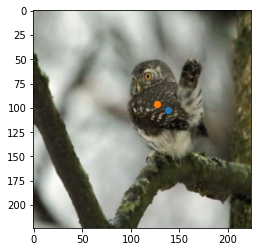

In [ ]:
sample = test_set[4] 

image = sample['image']
xy = sample['xy']
label = sample['label']


with torch.no_grad():
    xy_pred = net(torch.unsqueeze(image, dim=0).to(device)).cpu().numpy()[0]

show_image(image, xy, xy_pred=xy_pred)

### Вывод:

Не самый впечатляющий результат. 
В дальнейшем:
- увеличу датасет 
- устраню ошибку с названиями файлов
- попробую Yolo